In [ ]:
import torch
from models.convolutional_vae import ConvolutionalVAE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_filters = 128
latent_dim = 128
feature_dim=[2,2]

model = ConvolutionalVAE(
    in_channels=10, 
    num_filters=num_filters, 
    latent_dim=latent_dim,
    feature_dim=feature_dim,
).to(device)

checkpoint = torch.load('../../checkpoints/conv_vae_batchnorm_epoch.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

512


<All keys matched successfully>

In [2]:
import glob
import os
import json
import re

model.eval()
z_list = []
labels_list = []

folder_path = "../../data/evaluation"
json_files = glob.glob(os.path.join(folder_path, "*.json"))

puzzle_ids = []

train_data = {}
test_inputs = {}
test_outputs = {}

for file in json_files:
    with open(file, "r", encoding="utf-8") as f:
        data = json.load(f)
        puzzle_id = re.search(r"([\da-f]+)\.json$", file).group(1)

        puzzle_ids.append(puzzle_id)
        train_data[puzzle_id] = data["train"]
        test_inputs[puzzle_id] = data["test"][0]['input']
        test_outputs[puzzle_id] = data["test"][0]['output']

/Users/alexandermirchev/Dev/thesis/arc-agi-compression-experiments/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset size after augmentation: 1363 -> 1363


/Users/alexandermirchev/Dev/thesis/arc-agi-compression-experiments/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alexandermirchev/Dev/thesis/arc-agi-compression-experiments/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


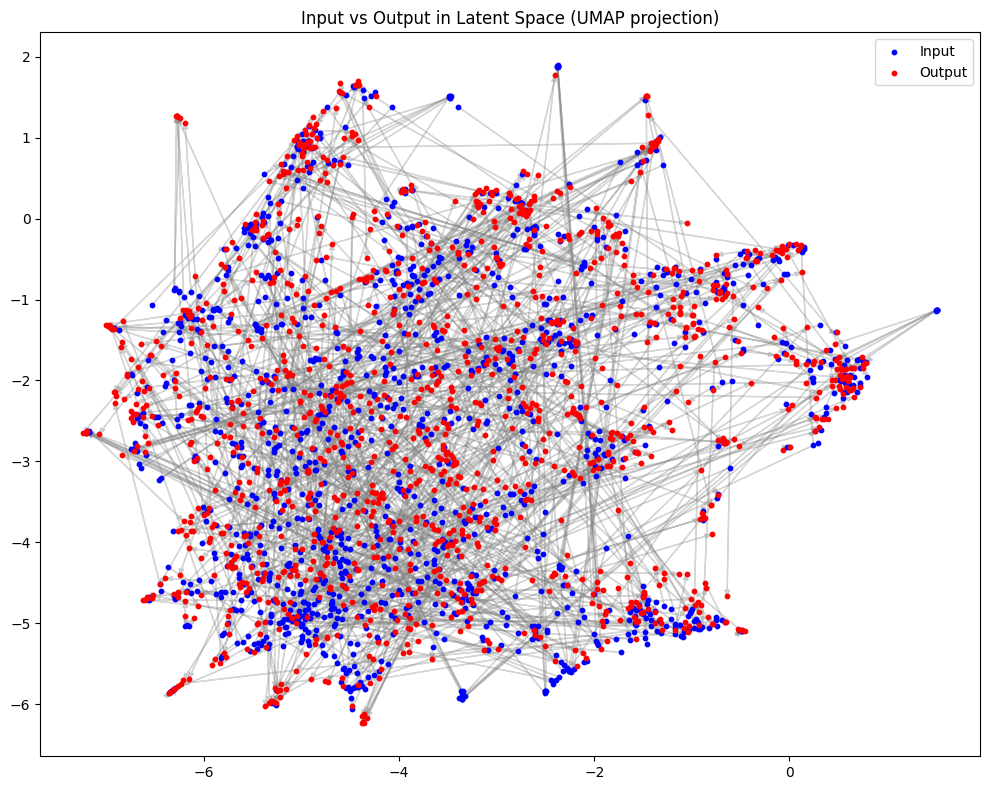

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import umap

from data.scale_processing import scaling
from data.arc_dataset import PairedGridDataset
from models.convolutional_vae import DataLoader

def normalize_fn(x, hw):
        h, w = hw
        # Normalize the grid to the target size
        return scaling(x, height=h, width=w, direction='norm')

training_grid_pairs = [(pair['input'], pair['output']) for puzzle_id in puzzle_ids for pair in train_data[puzzle_id]]
train_dataset = PairedGridDataset(training_grid_pairs, augment=False, normalize_fn=normalize_fn)

batch_size = 1
data_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
)
model.eval()
input_latents = []
output_latents = []

with torch.no_grad():
    for _, (input, output) in enumerate(data_loader):
        input = input.to(device)
        output = output.to(device)
        
        mu_in, _ = model.encode(input)
        mu_out, _ = model.encode(output)

        input_latents.append(mu_in.cpu().numpy())
        output_latents.append(mu_out.cpu().numpy())

input_latents = np.concatenate(input_latents, axis=0)
output_latents = np.concatenate(output_latents, axis=0)
combined_latents = np.vstack([input_latents, output_latents])

reducer = umap.UMAP(n_components=2, random_state=42)
latent_2d = reducer.fit_transform(combined_latents)

N = input_latents.shape[0]
input_2d = latent_2d[:N]
output_2d = latent_2d[N:]

plt.figure(figsize=(10, 8))
for i in range(N):
    plt.arrow(input_2d[i, 0], input_2d[i, 1],
              output_2d[i, 0] - input_2d[i, 0],
              output_2d[i, 1] - input_2d[i, 1],
              color='gray', alpha=0.3, head_width=0.05, length_includes_head=True)

plt.scatter(input_2d[:, 0], input_2d[:, 1], color='blue', s=10, label='Input')
plt.scatter(output_2d[:, 0], output_2d[:, 1], color='red', s=10, label='Output')
plt.title("Input vs Output in Latent Space (UMAP projection)")
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
import torch.nn.functional as F
from utils.view import draw_grid

def interpolate_between_samples(vae, input, output, num_steps=10):
    vae.eval()
    x_out = []
    with torch.no_grad():
        for i in range(output.shape[0]):
            x1 = input[i].unsqueeze(0).to(device)
            x2 = output[i].unsqueeze(0).to(device)

            # Take only the first sample in each batch
            x1 = x1[0].unsqueeze(0).to(device)
            x2 = x2[0].unsqueeze(0).to(device)

            mu1, _ = vae.encode(x1)
            mu2, _ = vae.encode(x2)

            # Interpolate between mu1 and mu2 across steps
            z_interp = torch.stack([
                torch.lerp(mu1, mu2, t) for t in torch.linspace(0, 1, num_steps).to(device)
            ])  # shape: (num_steps, 128)

            # Decode
            out = vae.decode(z_interp)
            out = torch.argmax(F.softmax(out, dim=1), dim=1)  # if output is logits over classes
            x_out.append(out.cpu().squeeze())

    print(np.array(x_out).shape)
    for i in range(len(x_out)):
        # Plotting
        fig, axes = plt.subplots(1, num_steps, figsize=(15, 6))
        for step in range(num_steps):
            draw_grid(axes[step], x_out[i][step])
        plt.suptitle(f"Interpolation in Latent Space")
        plt.show()


# for _, (input,output) in enumerate(data_loader):
    # interpolate_between_samples(model, input, output, num_steps=5)

In [5]:
all_latents = []  # list to hold latent vectors
for (input, output) in data_loader:
    mu, logvar = model.encode(input.to(device))
    z = model.reparameterize(mu, logvar)
    all_latents.append(z)

    mu, logvar = model.encode(output.to(device))
    z = model.reparameterize(mu, logvar)
    all_latents.append(z)

latents = torch.cat(all_latents, dim=0)

mean_vector = latents.mean(dim=0)  # Mean of each latent dimension
overall_mean = mean_vector.mean()  # Scalar average of all means (optional)

print("Mean per dimension:", mean_vector)
print("Overall mean:", overall_mean.item())

Mean per dimension: tensor([ 5.1972e-02,  4.4872e-02,  5.7130e-03, -6.5560e-02, -3.7136e-03,
        -4.7924e-02, -1.4846e-01, -2.7663e-01,  3.4753e-02,  1.2378e-02,
        -6.5193e-02, -4.1933e-01,  9.6895e-02,  4.9875e-02, -3.3224e-02,
        -2.4766e-02, -1.0884e-01,  8.6412e-03,  6.6583e-02, -1.7697e-02,
         5.3216e-03, -8.3042e-02,  1.4018e-02, -1.2777e-02,  4.8803e-02,
        -2.0314e-02,  1.6358e-02, -1.5681e-01,  1.0790e-02,  8.5168e-02,
         5.7165e-02, -7.4868e-02,  3.2303e-02, -1.7331e-01, -1.2250e-01,
        -4.5836e-02, -2.5884e-02, -5.4345e-02, -6.6850e-03,  3.7515e-03,
        -1.5034e-01, -2.4258e-02,  2.4636e-02,  4.1178e-02,  2.3438e-03,
         8.0128e-02,  1.2250e-01, -5.4890e-02,  5.5146e-03,  1.7513e-02,
        -1.0587e-01,  1.2625e-01, -5.7185e-02,  4.6940e-02, -2.2633e-02,
        -3.1187e-02,  2.5755e-02, -3.6646e-02, -1.0968e-02,  2.5627e-02,
        -5.2680e-03, -1.2865e-02, -4.7246e-03,  8.7564e-02, -1.6544e-01,
         4.0002e-02,  3.7166e-0

In [6]:
std_vector = latents.std(dim=0)
overall_std = std_vector.mean()

print("Std per dimension:", std_vector)
print("Average std across dimensions:", overall_std.item())

Std per dimension: tensor([0.9474, 0.9462, 1.0258, 0.9599, 0.9916, 1.0119, 0.9854, 0.8751, 1.0123,
        0.9805, 0.9718, 0.9010, 1.0186, 0.9916, 0.9893, 0.9836, 0.8905, 0.9683,
        0.9988, 0.9823, 1.0367, 0.9943, 0.9913, 0.9892, 1.0442, 1.0061, 0.9923,
        0.9866, 0.9991, 0.9965, 1.0038, 0.9834, 0.9754, 0.9641, 0.9775, 1.0107,
        1.0106, 1.0005, 1.0075, 0.9926, 0.9689, 0.9791, 1.0084, 0.9844, 0.9998,
        0.9718, 0.9519, 1.0046, 1.0090, 0.9895, 1.0018, 0.9130, 0.9863, 1.0005,
        0.9589, 0.9725, 0.9862, 0.9861, 1.0194, 1.0141, 0.9963, 0.9897, 0.9922,
        0.8561, 0.9734, 0.9603, 0.9813, 0.9579, 0.9740, 0.9858, 0.9825, 0.8269,
        1.0043, 0.9676, 1.0076, 0.9804, 1.0006, 0.9789, 0.9998, 0.9998, 1.0043,
        1.0145, 0.9954, 0.9855, 0.9821, 0.9756, 1.0035, 1.0008, 0.9902, 0.8697,
        1.0049, 1.0087, 1.0272, 1.0408, 1.0216, 0.8744, 1.0435, 1.0168, 0.9403,
        1.0043, 1.0168, 0.9630, 0.9701, 0.9626, 0.9766, 0.9857, 1.0032, 0.9920,
        0.9802, 0.998

/Users/alexandermirchev/Dev/thesis/arc-agi-compression-experiments/.venv/lib/python3.12/site-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/Users/alexandermirchev/Dev/thesis/arc-agi-compression-experiments/.venv/lib/python3.12/site-packages/hdbscan/robust_single_linkage_.py:154: SyntaxWarning: invalid escape sequence '\{'
  """Perform robust single linkage clustering from a vector array
/Users/alexandermirchev/Dev/thesis/arc-agi-compression-experiments/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alexandermirchev/Dev/thesis/arc-agi-compression-experiments/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/x_/1hf63s3j2m7bc3

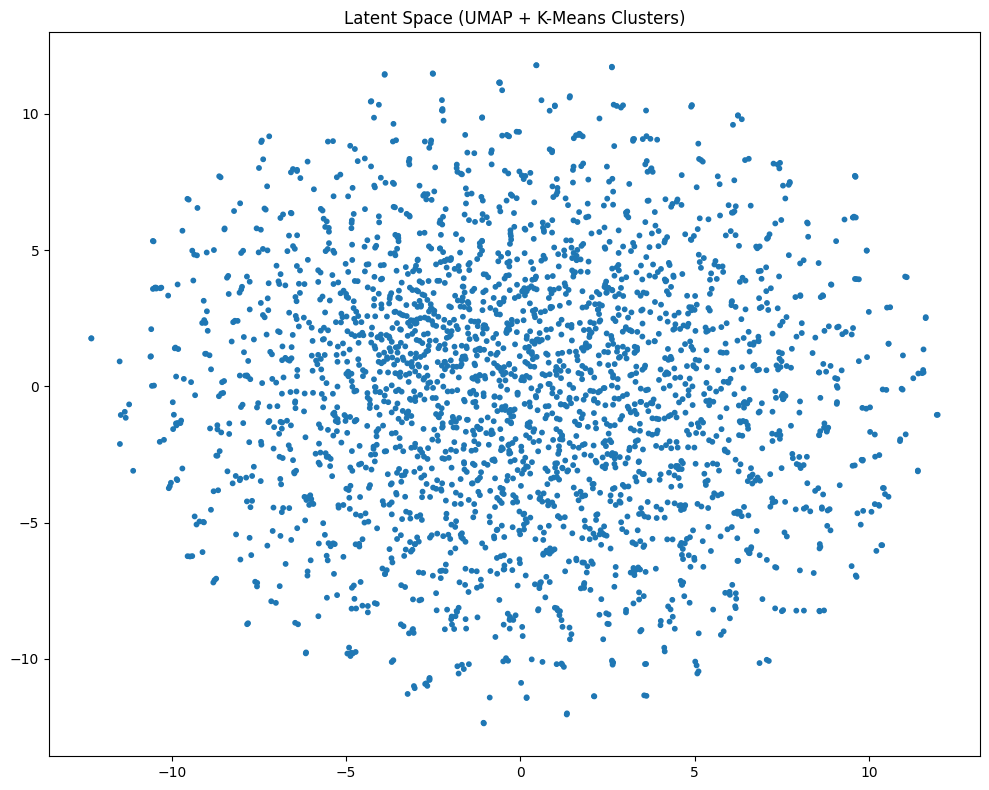

In [ ]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import hdbscan

import matplotlib.cm as cm

z = []
for (input, output) in data_loader:
    with torch.no_grad():
        mu, logvar = model.encode(input.to(device))
        z_vec = model.reparameterize(mu, logvar)
        z.append(z_vec)

        mu, logvar = model.encode(output.to(device))
        z_vec = model.reparameterize(mu, logvar)
        z.append(z_vec)

z = torch.cat(z, dim=0)  # shape [2*N, latent_dim]
z_np = z.detach().cpu().numpy()
z_scaled = StandardScaler().fit_transform(z_np)

# labels = KMeans(n_clusters=5).fit_predict(z)
# labels = GaussianMixture(n_components=2).fit_predict(z_np)
# labels = DBSCAN(eps=2, min_samples=5).fit_predict(z_scaled)
labels = hdbscan.HDBSCAN(min_cluster_size=5).fit_predict(z_scaled)

# reducer = umap.UMAP(n_components=2, random_state=42)
# latent_2d = reducer.fit_transform(z_scaled)  # shape: [2*N, 2]

tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(z_np)

# Create colors from labels
num_clusters = len(np.unique(labels))
cmap = cm.get_cmap('tab10', num_clusters)
colors = [cmap(l) for l in labels]

# Plot all points together
plt.figure(figsize=(10, 8))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=colors, s=10)
plt.title("Latent Space (UMAP + K-Means Clusters)")
plt.tight_layout()
plt.show()

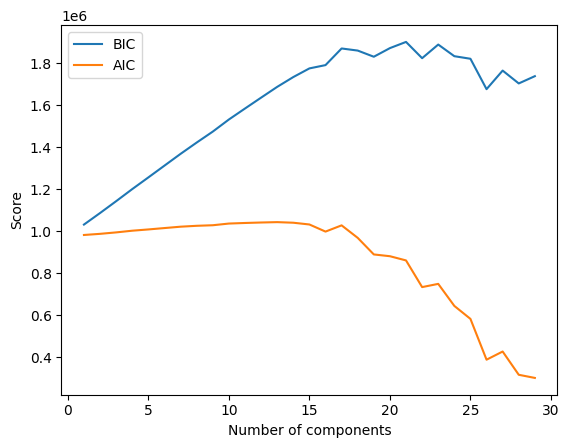

In [28]:
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt

size = 30
bics = []
aics = []

for n_components in range(1, size): 
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(z_np)
    bics.append(gmm.bic(z_np))
    aics.append(gmm.aic(z_np))

plt.plot(range(1, size), bics, label='BIC')
plt.plot(range(1, size), aics, label='AIC')
plt.legend()
plt.xlabel('Number of components') 
plt.ylabel('Score')
plt.show()

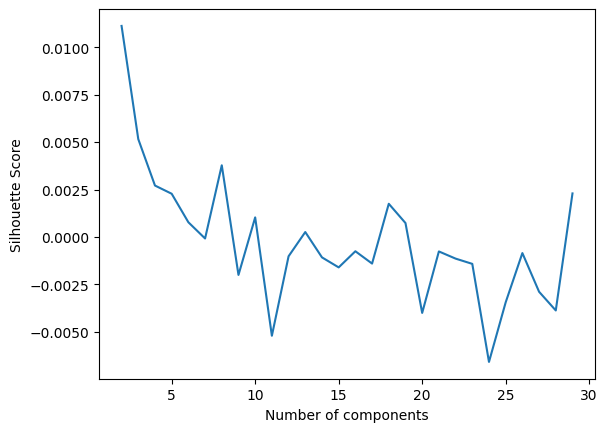

In [29]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for n_components in range(2, size):  # Start from 2 because silhouette score requires at least 2 clusters
    gmm = GaussianMixture(n_components=n_components)
    labels = gmm.fit_predict(z_np)
    silhouette_scores.append(silhouette_score(z_np, labels))

# Plot Silhouette Score
plt.plot(range(2, size), silhouette_scores)
plt.xlabel('Number of components')
plt.ylabel('Silhouette Score')
plt.show()

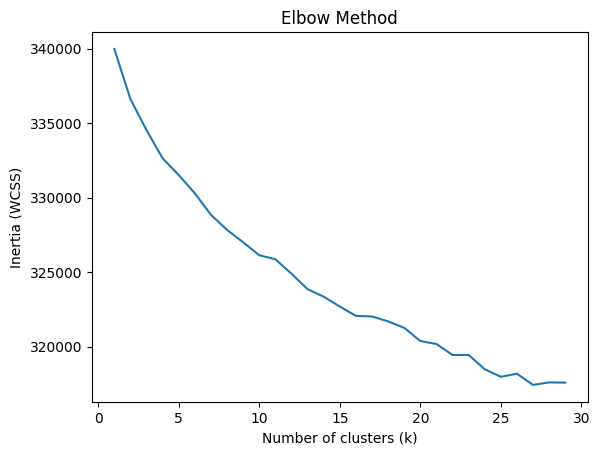

In [30]:
inertia = []

for k in range(1, size):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(z_np)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, size), inertia)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method')
plt.show()

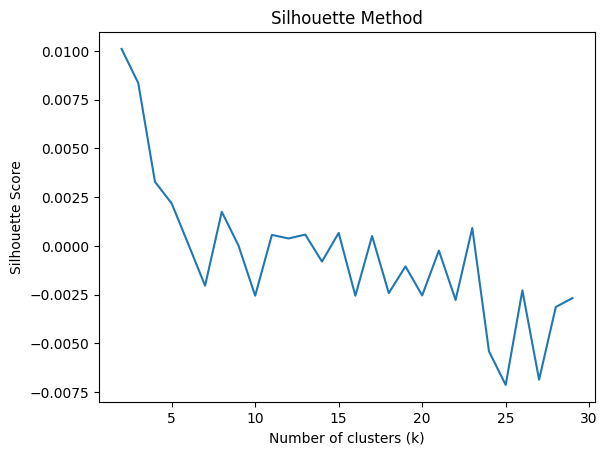

In [31]:
sil_scores = []

for k in range(2, size):
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(z_np)
    sil_scores.append(silhouette_score(z_np, labels))

plt.plot(range(2, size), sil_scores)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.show()

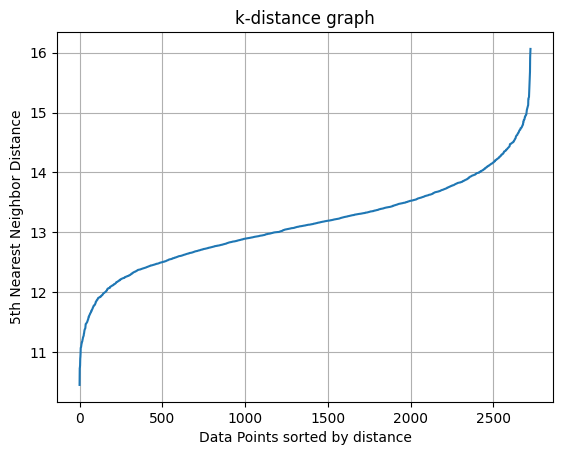

In [33]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(z_np)

k = 5  
nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# Sort distances to get the elbow
distances = np.sort(distances[:, k-1])
plt.plot(distances)
plt.title("k-distance graph")
plt.xlabel("Data Points sorted by distance")
plt.ylabel(f"{k}th Nearest Neighbor Distance")
plt.grid(True)
plt.show()